Feel free to change num_threads to suit your computational resources. 

In [2]:
%env NUMBA_WARNINGS 1
%env NUMBA_NUM_THREADS 4

import ctypes
mkl_rt = ctypes.CDLL('libmkl_rt.so')
print(mkl_rt.mkl_get_max_threads())
mkl_get_max_threads = mkl_rt.mkl_get_max_threads
def mkl_set_num_threads(cores):
    mkl_rt.mkl_set_num_threads(ctypes.byref(ctypes.c_int(cores)))
mkl_set_num_threads(4)
print(mkl_get_max_threads())

env: NUMBA_WARNINGS=1
env: NUMBA_NUM_THREADS=4
16
4


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import os
import pickle as pkl
from telepyth import TelepythClient
import time

from experiment import relative_errors
from dataset import make_dataset, sample_dataset
from visualize import plot_errors

Use token from .telepythrc.


In [9]:
# will send a notification, picture or text to your Telegram chat when calculations are ready
tp = TelepythClient()

# USPS

In [5]:
approx_types = ['G', 'Gort', 'ROM', 'QMC', 'GQ', 'B']
# halton sequence generator cannot generate large enough sequences for datasets CIFAR100 and LEUKEMIA
approx_types_large_d = ['G', 'Gort', 'ROM', 'B']
datasets = ['Powerplant', 'LETTER', 'USPS'] #, 'MNIST'] #, 'CIFAR100', 'LEUKEMIA']
kernels = ['Arccos 0', 'Arccos 1', 'RBF']

In [11]:
%%time
%%telepyth
errs = {}
# set sample_params = None to get default parameters as in the paper, but be aware it takes long time
sample_params = [1, 3, 10, 0, 1, 5, 50]
for name in datasets:
    print(name)
    errs[name] = {}
    dataset, params = make_dataset(name, sample_params)
    start_deg, max_deg, runs, shift, step, nsamples, _ = params

    X = sample_dataset(nsamples, dataset)
    Y = sample_dataset(nsamples, dataset)
    
    if X.shape[1] > 784:
        approx_types = approx_types_large_d
        
    for kernel in kernels:
        errs[name][kernel] = relative_errors(X, Y, kernel, approx_types, start_deg, max_deg, step, shift, runs)
        
    directory = 'results/%s/' % name
    if not os.path.exists(directory):
        os.makedirs(directory)

    with open(directory + '%s_%r_%r' % (name, kernels, params), 'wb') as f:
        pkl.dump(errs, f)

100%|██████████| 6/6 [00:00<00:00, 94.32it/s]

Powerplant
LETTER



  0%|          | 0/6 [00:00<?, ?it/s]

USPS


100%|██████████| 6/6 [00:04<00:00,  1.46it/s]


CPU times: user 53.6 s, sys: 892 ms, total: 54.4 s
Wall time: 13.9 s


# Plot kernel approximation accuracy

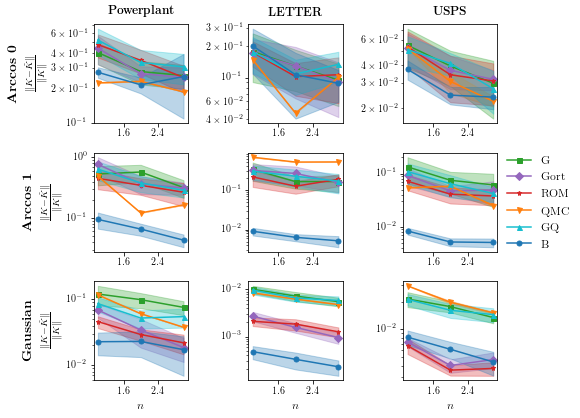

200

In [10]:
fig = plot_errors(errs, datasets, kernels, approx_types, semilogy=True, acc=False, exact=None, params=sample_params)
tp.send_figure(fig, 'Kernel approximation results.')